## Problem Statement/Overview

NLP, or Natural Language Processing, is an overlap between linguistics and computing, and in the case of data science, it is using the tools of computer programming to understand and analyze elements of human speech and communication.

In this specific instance, we are using text scraped from the social media platform Twitter. Twitter is a "microblogging" site often used by individuals on mobile devices, and is therefore useful for communication in various situations. In the use-case for which our data is pulled, we determine whether Tweets from individuals are taken from actual natural disasters or not. 

Because our data is comprised of text, it is encoded in .csv files. We have a train and test csv file, as well as a sample submission csv. Combined, these three files are 1.43mb and are easily downloadable from Kaggle. The training file contains and id field, and columns for 'keyword', 'location', 'text', and 'target', with target being our classification we plan to assign on the testing data after training the model. Our training dataset has about 7.6K observations, while our test set has about 3.2K.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers, preprocessing
from tensorflow.keras.layers import GRU, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence, one_hot
import keras.backend as K

In [4]:
PATH = '/kaggle/input/nlp-getting-started/'
df_training = pd.read_csv(PATH+'train.csv')
df_training

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## Exploratory Data Analysis

We saw above that our training dataset has 5 columns and 7,613 rows. First, let's check out how complete the dataset is.

In [5]:
for col in df_training.columns:
    colnulls = df_training[col].isna().sum()
    print(col, '   ', colnulls, "nulls,       ", round(colnulls/len(df_training)*100,1),"% of total.")

id     0 nulls,        0.0 % of total.
keyword     61 nulls,        0.8 % of total.
location     2533 nulls,        33.3 % of total.
text     0 nulls,        0.0 % of total.
target     0 nulls,        0.0 % of total.


We have just a few null observations for keyword, while about a third of observations lack information for the 'location' column. Below, let's get a sense of some of the top keywords and locations.

In [6]:
print(df_training.keyword.value_counts())
print(df_training.location.value_counts())

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64


And now let's look at an important factor: how is our training data distributed between our two classes in which we hope to sort observations. As a reminder, a target value of 1 indicates a real disaster, while a value of 0 indicates against.

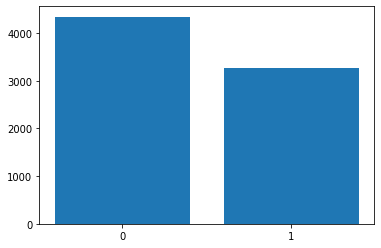

In [7]:
plt.bar([0, 1], df_training.target.value_counts())
plt.xticks([0, 1], [0, 1])

plt.show()

Finally, let's look at the text itself. Below is some code to generate the longest and shortest tweets in our dataset (as well as their character counts), and below that is a visual representation of the distribution of these Tweet lengths.

In [8]:
longest = [0, None]
shortest = [1000, None]
for i in range(0, len(df_training.text)):
    if len(df_training.loc[i, 'text']) > longest[0]:
        longest = [len(df_training.loc[i, 'text']), df_training.loc[i, 'text']]
    if len(df_training.loc[i, 'text']) < shortest[0]:
        shortest = [len(df_training.loc[i, 'text']), df_training.loc[i, 'text']]
        
print(longest)
print(shortest)

[157, "when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"]
[7, 'Crushed']


<BarContainer object of 151 artists>

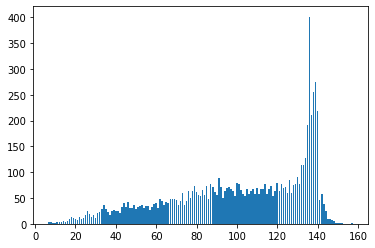

In [9]:
characters = list(np.arange(7, 158, 1))
tweets = list(np.zeros(len(characters)))

characters.index(14)

for j in range(0, len(df_training.text)):
    tweets[characters.index(len(df_training.loc[j, 'text']))]+=1
    
plt.bar(characters, tweets)

## Data Preprocessing

An important step in NLP is processing text so that it can be readable and usable by a model such as a neural network. Below is the process of formatting our input data and standardizing/lemmatizing using some code from another programmer. The citation is commented in the codeblock.

In [10]:
train = pd.read_csv(PATH+'train.csv')   
test = pd.read_csv(PATH+'test.csv') 

x_train = train["text"].to_numpy(dtype=str).reshape(-1, 1)
y_train = train["target"].to_numpy(dtype=int).reshape(-1, 1)

x_test = test["text"].to_numpy(dtype=str).reshape(-1, 1)
id_test = test["id"].to_numpy(dtype=int).reshape(-1, 1)

In [11]:
### Data preprocessing from https://www.kaggle.com/code/benjaminahlbrecht/nlp-with-disaster-tweets

def text_standardization(text):
    text_lowercase = tf.strings.lower(text)
    text_standardized = tf.strings.regex_replace(
        input=text_lowercase,
        pattern=r"[.?!]",
        rewrite=" ")
    text_standardized = tf.strings.regex_replace(
        input=text_standardized,
        pattern=r"[#,\'\"]",
        rewrite="")
    text_standardized = tf.strings.strip(text_standardized)
    return text_standardized

def text_preprocessor(x_train, y_train, x_test, id_test, text_standardizer, max_tokens:int=1000, sequence_length:int=30, train_split:float=0.8, batch_size:int=32):
    n = x_train.shape[0]
    train_size = int(n * train_split)
    shuffler = np.arange(n)
    np.random.shuffle(shuffler)
    x_train_shuffled = x_train[shuffler]
    y_train_shuffled = y_train[shuffler]
    vectorization_layer = layers.TextVectorization(
        standardize=text_standardizer,
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=sequence_length)
    vectorization_layer.adapt(x_train_shuffled[:train_size])
    x_train = vectorization_layer(x_train_shuffled[:train_size])
    y_train = y_train_shuffled[:train_size]
    x_validation = vectorization_layer(x_train_shuffled[train_size:])
    y_validation = y_train_shuffled[train_size:]
    x_test = vectorization_layer(x_test)
    data = {
        "x_train": np.expand_dims(x_train, -1),
        "y_train": y_train,
        "x_validation": np.expand_dims(x_validation, -1),
        "y_validation": y_validation,
        "x_test": np.expand_dims(x_test, -1),
        "id_test": id_test}
    return (data, vectorization_layer)

data, vectorization_layer = text_preprocessor(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    id_test=id_test,
    text_standardizer=text_standardization,
    max_tokens=1000,
    sequence_length=30)

2022-10-27 14:20:09.534009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:20:09.534974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:20:09.685679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:20:09.686520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 14:20:09.687279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
## F1 for compiler, here: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc.

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Model Architecture: GRU

First, we're going to try a GRU, or Gated Recurrent Unit. This is an appropriate model to use for a task like this because it takes into account previous information learned in an observation, such as earlier words within a single observation. In other words, all the words of a tweet matter, but their relationship to one another is also counted to some extent.

This first attempt will use a bidirectional GRU followed by two dense layers. The final output layer will have a single output, which is our target.

As an additional bonus, we are using F1 as our metric when compiling the model since that is what our test data will be scored on in the Kaggle competition. This metric definition has been declared above, as well as a link to the blog by Aakash Goel, from which the code has been generously lifted after originally being adapted from the Keras backend.

In [13]:
input_layer = layers.Input(shape=(30,), name="input")
f = layers.Embedding(1000, 6, input_length=30, name="embedding")(input_layer)
f = layers.Bidirectional(layers.GRU(32, activation="leaky_relu", recurrent_dropout=0.5, name="GRU_model"))(f)
f = layers.Dense(16, activation="leaky_relu", name="dense_1")(f)
f = layers.Dropout(0.5, name="dense_1_dropout")(f)
output_layer = layers.Dense(1, activation="sigmoid", name="dense_2_output")(f)
model = keras.Model(inputs=input_layer, outputs=output_layer, name="GRU_model")
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[get_f1])

model.summary()

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 6)             6000      
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                7680      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_1_dropout (Dropout)    (None, 16)                0         
_________________________________________________________________
dense_2_output (Dense)       (None, 1)                 17        
Total params: 14,737
Trainable params: 14,737
Non-trainable params: 0
_____________________________________________________

In [14]:
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

hist = model.fit(data["x_train"], data["y_train"], 
    validation_data=(data["x_validation"], data["y_validation"]), 
    batch_size=batch_size, 
    callbacks=[callback],
    epochs=15
)

Epoch 1/15
191/191 [==============================] - 47s 219ms/step - loss: 0.6729 - get_f1: 0.0512 - val_loss: 0.5942 - val_get_f1: 0.6626
Epoch 2/15
191/191 [==============================] - 41s 212ms/step - loss: 0.5120 - get_f1: 0.6944 - val_loss: 0.4727 - val_get_f1: 0.6933
Epoch 3/15
191/191 [==============================] - 41s 217ms/step - loss: 0.4412 - get_f1: 0.7435 - val_loss: 0.4598 - val_get_f1: 0.7317
Epoch 4/15
191/191 [==============================] - 41s 213ms/step - loss: 0.4217 - get_f1: 0.7550 - val_loss: 0.4659 - val_get_f1: 0.7531
Epoch 5/15
191/191 [==============================] - 40s 208ms/step - loss: 0.4059 - get_f1: 0.7700 - val_loss: 0.4622 - val_get_f1: 0.7336
Epoch 6/15
191/191 [==============================] - 41s 216ms/step - loss: 0.3978 - get_f1: 0.7761 - val_loss: 0.4600 - val_get_f1: 0.7137
Epoch 7/15
191/191 [==============================] - 40s 210ms/step - loss: 0.3873 - get_f1: 0.7831 - val_loss: 0.4664 - val_get_f1: 0.7247
Epoch 8/15
19

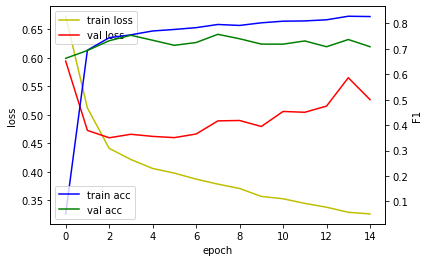

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['get_f1'], 'b', label='train acc')
acc_ax.plot(hist.history['val_get_f1'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('F1')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Model Architecture: LSTM

Finally, we try out a LSTM, or Long Short-Term Memory. This is another type of advanced RNN. Like with the GRU above, the intention of this type of model is to retain some of the information already learned about the observation (the "long term" memory) and combine that with the newest information. In this simple version of the model (for maximum comparability with the GRU), we are using a bidirectional LSTM layer followed by two denxe layers. Agsin, we use the custom-defined F1 metric in the compiler to end with just over 17K trainable parameters.

In [17]:
## LSTM model
input_layer = layers.Input(shape=(30,), name="input")
k = layers.Embedding(1000, 6, input_length=30, name="embedding")(input_layer)
k = layers.Bidirectional(layers.LSTM(32, activation="leaky_relu", recurrent_dropout=0.5), name='lstm')(k)
k = layers.Dense(16, activation="leaky_relu", name="dense_1")(k)
k = layers.Dropout(0.5, name="dense_1_dropout")(k)
output_layer = layers.Dense(1, activation="sigmoid", name="dense_2_output")(k)
    
lstm_model = keras.Model(inputs=input_layer, outputs=output_layer, name='lstm')
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[get_f1])

lstm_model.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 6)             6000      
_________________________________________________________________
lstm (Bidirectional)         (None, 64)                9984      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_1_dropout (Dropout)    (None, 16)                0         
_________________________________________________________________
dense_2_output (Dense)       (None, 1)                 17        
Total params: 17,041
Trainable params: 17,041
Non-trainable params: 0
__________________________________________________________

In [18]:
batch_size = 32

lstm_history = lstm_model.fit(data["x_train"], data["y_train"], 
    validation_data=(data["x_validation"], data["y_validation"]), 
    batch_size=batch_size, 
    callbacks=[callback],
    epochs=15
)

Epoch 1/15
191/191 [==============================] - 52s 249ms/step - loss: 0.6580 - get_f1: 0.1990 - val_loss: 0.5814 - val_get_f1: 0.6764
Epoch 2/15
191/191 [==============================] - 47s 247ms/step - loss: 0.5309 - get_f1: 0.6496 - val_loss: 0.4961 - val_get_f1: 0.6797
Epoch 3/15
191/191 [==============================] - 46s 241ms/step - loss: 0.4577 - get_f1: 0.7338 - val_loss: 0.4679 - val_get_f1: 0.7345
Epoch 4/15
191/191 [==============================] - 46s 241ms/step - loss: 0.4248 - get_f1: 0.7525 - val_loss: 0.4572 - val_get_f1: 0.7171
Epoch 5/15
191/191 [==============================] - 47s 248ms/step - loss: 0.4034 - get_f1: 0.7655 - val_loss: 0.4552 - val_get_f1: 0.7196
Epoch 6/15
191/191 [==============================] - 49s 259ms/step - loss: 0.3962 - get_f1: 0.7800 - val_loss: 0.4573 - val_get_f1: 0.7275
Epoch 7/15
191/191 [==============================] - 48s 252ms/step - loss: 0.3847 - get_f1: 0.7890 - val_loss: 0.4714 - val_get_f1: 0.7286
Epoch 8/15
19

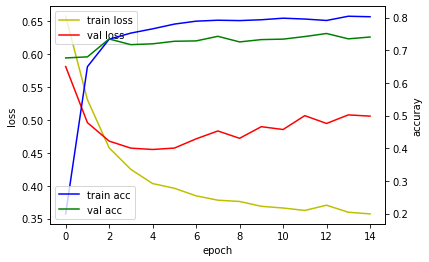

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(lstm_history.history['loss'], 'y', label='train loss')
loss_ax.plot(lstm_history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(lstm_history.history['get_f1'], 'b', label='train acc')
acc_ax.plot(lstm_history.history['val_get_f1'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Results and Analysis

In earlier iterations of the two model architectures above, I had tried a couple different tweaks to hyperparameters:

-Including/not including early stopping,

-As few as four epoch training, up to 15,

-Using accuracy as the metric rather than the custom F1.

In the end, most of these yielded very small changes in the training/validation and even test accuracy that these models could achieve. In the end, my scores within the actual Kaggle competition dataset were in the high 70s, between 0.765 and 0.785.

More than likely, the changes that could be made to achieve a higher score have to do with the larger elements of RNN architecture, namely the cardinality and orientation of the layers, possibly adding on more parameters. It appeared that we are nowhere near overfitting the model, and therefore can look into adding more layers in the future.

The other route to go can be in preprocessing. While I borrowwed a preprocessing set of steps from another colleague who included a particular amount of words included, there are plenty of tweaks that can be made with preprocessing.

In [20]:
predictions_raw = model.predict(data['x_test'])
predictions = np.round(predictions_raw).astype(int).flatten()

GRU_submit = pd.DataFrame({'id': id_test.flatten(), 'target': predictions})
GRU_submit = GRU_submit.set_index('id')
GRU_submit.to_csv('GRU_submit.csv')

lstm_predictions_raw = lstm_model(data['x_test'])
lstm_predictions = np.round(lstm_predictions_raw).astype(int).flatten()

LSTM_submit = pd.DataFrame({'id': id_test.flatten(), 'target': lstm_predictions})
LSTM_submit = LSTM_submit.set_index('id')
LSTM_submit.to_csv('LSTM_submit.csv')

## Conclusion

In this NLP exercise, we saw that it's important to keep in mind all the factors that can increase or decrease outcomes for an RNN neural network, and in the context of NLP, this can range from preprocessing to model architecture, to using the right metric and early stopping. 

Additionally, I think it's imporant to note two things about this dataset specifically. First of all, it is quite small all things considedered. There are millions of Tweets composed and published every day, while there are quite possibly billions of social media posts. When considering this set of 10K messages as part of this dataset in that context, what we're looking at is a very small sample size, especially considering most social media messages around the world do not have to do with some sort of disaster (and would therefore be coded as 0 in this exercise).

That said, with multi-epoch training, these models began to take time to train, and imagining the same process with 10x or 100x the input data is interesting because of 1) the possibility of increased accuracy but 2) the increased computer power needed. This goes to show the importance of tuning all possible hyperparameters and tinkering around with different layers first, as it is easier to re-train different versions of models over and over on smaller datasets rather than training a single model on a large dataset and simply hoping for accurate results.